In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Setup

### Configure your API keys

To fine-tune Florence-2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `L4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Thu Sep 12 06:37:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   49C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install dependencies

In [ ]:
!pip install -q roboflow maestro==0.2.0rc3

## Download dataset

In [18]:
from roboflow import Roboflow
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

version = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio").version(4)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...


In [5]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_20220316_172418_jpg.rf.e3cb4a86dc0247e71e3697aa3e9db923.jpg","prefix":"<OD>","suffix":"9 of clubs<loc_138><loc_100><loc_470><loc_448>10 of clubs<loc_388><loc_145><loc_670><loc_453>jack  of clubs<loc_566><loc_166><loc_823><loc_432>queen of clubs<loc_365><loc_465><loc_765><loc_999>king of clubs<loc_601><loc_440><loc_949><loc_873>"}
{"image":"IMG_20220316_171515_jpg.rf.e3b1932bb375b3b3912027647586daa8.jpg","prefix":"<OD>","suffix":"5 of clubs<loc_554><loc_2><loc_763><loc_467>6 of clubs<loc_399><loc_79><loc_555><loc_466>7 of clubs<loc_363><loc_484><loc_552><loc_905>8 of clubs<loc_535><loc_449><loc_757><loc_971>"}
{"image":"IMG_20220316_165139_jpg.rf.e30257ec169a2bfdfecb693211d37250.jpg","prefix":"<OD>","suffix":"9 of diamonds<loc_596><loc_535><loc_859><loc_982>jack of diamonds<loc_211><loc_546><loc_411><loc_880>queen of diamonds<loc_430><loc_34><loc_692><loc_518>king of diamonds<loc_223><loc_96><loc_451><loc_523>10 of diamonds<loc_387><loc_542><loc_604><loc_925>"}
{"image":"I

## Fine-tune Florence-2 on detection dataset

In [6]:
!maestro florence2 train --help

                                                                                                    
 Usage: maestro florence2 train [OPTIONS]                                                           
                                                                                                    
 Train Florence 2 model                                                                             
                                                                                                    
╭─ Options ────────────────────────────────────────────────────────────────────────────────────────╮
│ *  --dataset                                 TEXT     Path to the dataset used for training      │
│                                                       [default: None]                            │
│                                                       [required]                                 │
│    --model_id                                TEXT     Identifier for the Florence-2 model

In [ ]:
!maestro florence2 train --dataset={dataset.location} --epochs=10 --batch_size=6 --lr=5e-6 --metrics mean_average_precision

## Evaluate Florence-2 on object detection task

In [12]:
!ls -la training/florence-2/1/metrics/

total 292
drwxr-xr-x 2 root root   4096 Sep 12 07:20 .
drwxr-xr-x 4 root root   4096 Sep 12 07:20 ..
-rw-r--r-- 1 root root  34790 Sep 12 07:20 loss_plot.png
-rw-r--r-- 1 root root  33205 Sep 12 07:20 map50:95_plot.png
-rw-r--r-- 1 root root  27222 Sep 12 07:20 map50_plot.png
-rw-r--r-- 1 root root  27175 Sep 12 07:20 map75_plot.png
-rw-r--r-- 1 root root 148141 Sep 12 07:20 training.json
-rw-r--r-- 1 root root   4375 Sep 12 07:20 validation.json


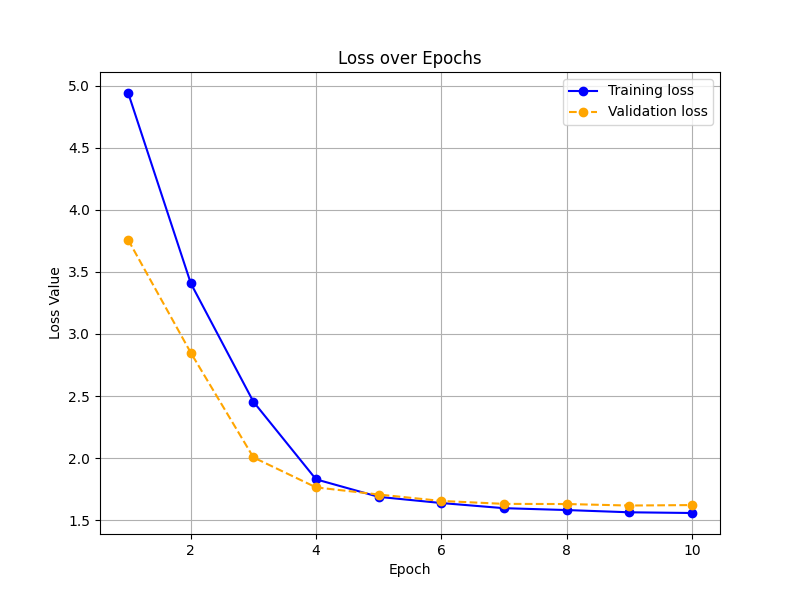

In [8]:
from IPython.display import display, Image

Image(filename='training/florence-2/1/metrics/loss_plot.png', height=600)

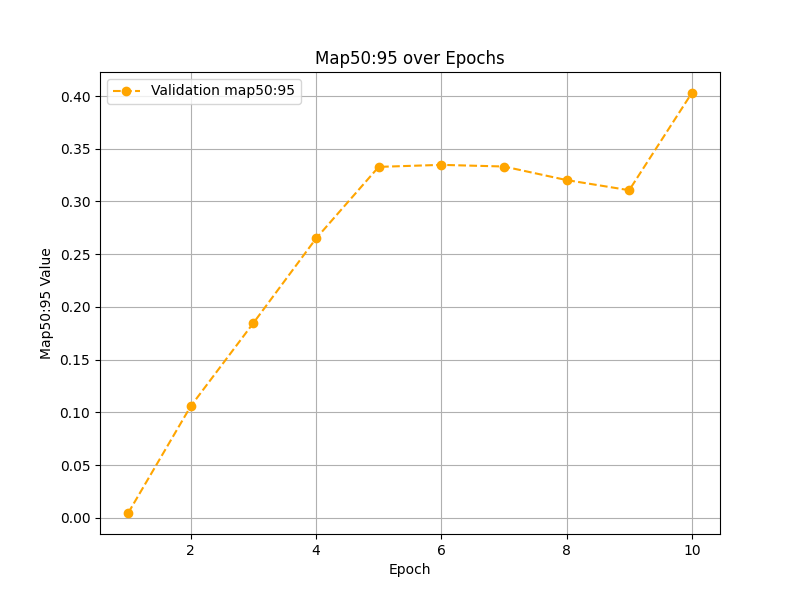

In [9]:
from IPython.display import display, Image

Image(filename='training/florence-2/1/metrics/map50:95_plot.png', height=600)

In [ ]:
!maestro florence2 evaluate \
--dataset={dataset.location} \
--model_id=/content/training/florence-2/1/checkpoints/best \
--metrics mean_average_precision

In [11]:
!cat /content/evaluation/florence-2/metrics/evaluation.json

{
    "map50:95": [
        {
            "epoch": 1,
            "step": 1,
            "value": 0.4431121794871794
        }
    ],
    "map50": [
        {
            "epoch": 1,
            "step": 1,
            "value": 0.4787499999999999
        }
    ],
    "map75": [
        {
            "epoch": 1,
            "step": 1,
            "value": 0.4739423076923076
        }
    ]
}

In [13]:
!ls -la training/florence-2/1/checkpoints/

total 16
drwxr-xr-x 4 root root 4096 Sep 12 06:42 .
drwxr-xr-x 4 root root 4096 Sep 12 07:20 ..
drwxr-xr-x 2 root root 4096 Sep 12 06:42 best
drwxr-xr-x 2 root root 4096 Sep 12 06:42 latest


## Run inference

In [15]:
from maestro.trainer.models.florence_2.checkpoints import load_model

processor, model = load_model(model_id_or_path="/content/training/florence-2/1/checkpoints/best")

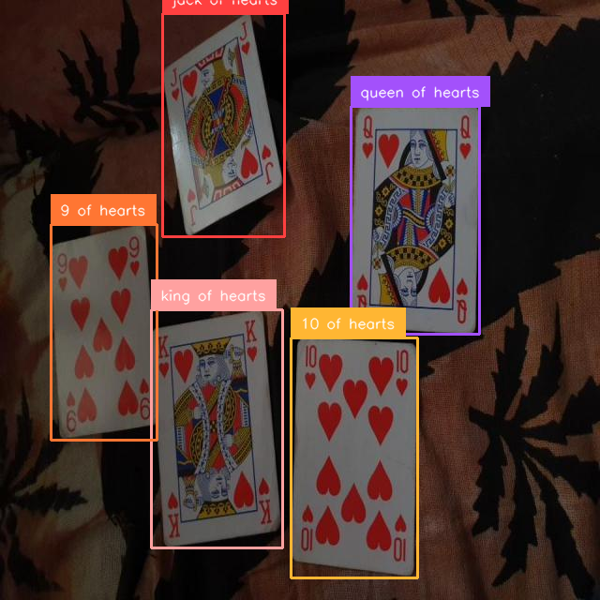

In [20]:
import supervision as sv
from maestro.trainer.common.data_loaders.datasets import JSONLDataset

ds = JSONLDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)

image, _ = ds[0]
text = "<OD>"
task = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to("cuda")
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=image.size)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image